# Global Imports


In [1]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import stats
import missingno as msno
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
import warnings
matplotlib.style.use('ggplot')
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore")
%matplotlib inline

### import data

In [3]:
train = pd.read_csv('train_2016_v2.csv', parse_dates=["transactiondate"])
properties = pd.read_csv('properties_2016.csv')

### shape of the Dataset

In [26]:
print('Shape of train', train.shape)
print('Shape of properties', properties.shape)

Shape of train (90275, 3)
Shape of properties (2985217, 58)


### Merge Train and Properties 

In [27]:
merged = pd.merge(train, properties, on= 'parcelid', how = 'left')

In [28]:
merged.head(5).transpose()

,0,1,2,3,4
parcelid,11016594,14366692,12098116,12643413,14432541
logerror,0.0276,-0.1684,-0.004,0.0218,-0.005
transactiondate,2016-01-01 00:00:00,2016-01-01 00:00:00,2016-01-01 00:00:00,2016-01-02 00:00:00,2016-01-02 00:00:00
airconditioningtypeid,1,NaN,1,1,NaN
architecturalstyletypeid,NaN,NaN,NaN,NaN,NaN
basementsqft,NaN,NaN,NaN,NaN,NaN
bathroomcnt,2,3.5,3,2,2.5
bedroomcnt,3,4,2,2,4
buildingclasstypeid,NaN,NaN,NaN,NaN,NaN
buildingqualitytypeid,4,NaN,4,4,NaN


### Datatypes Visulization

In [33]:
data_type_df = pd.DataFrame(merged.dtypes.value_counts()).reset_index().rename(columns={"index":"variableType", 0:"count"})
fig, ax = plt.subplots()
fig.set_size_inches(20,5)
sn.barplot(data=data_type_df, x='variableType', y='count', ax=ax, color = '#34495e')
#ax.set(xlabel = 'Variable Type', ylabel='Count', title='Variables Count Across Datatype')

TypeError: data type "" not understood

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x000001DE756029D8> (for post_execute):


TypeError: data type "" not understood

TypeError: data type "" not understood

<Figure size 1440x360 with 1 Axes>

### Missing Value Analysis

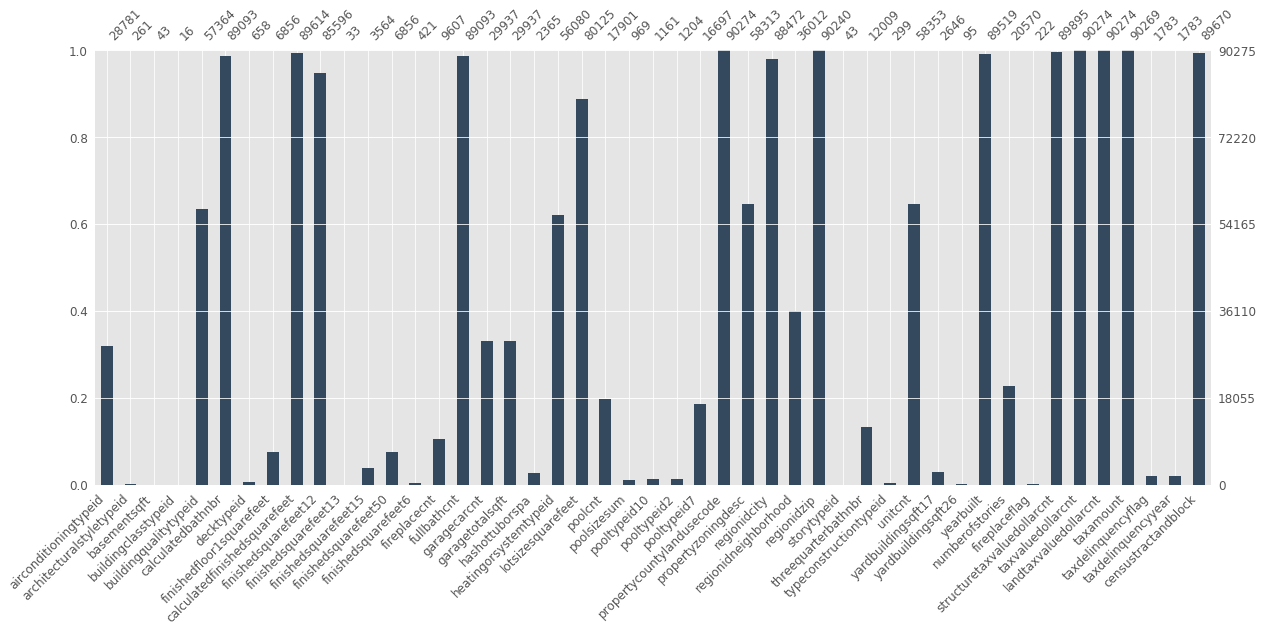

In [34]:
missing_value_columns = merged.columns[merged.isnull().any()].tolist()
msno.bar(merged[missing_value_columns], figsize = (20,8), color='#34495e', fontsize= 12, labels= True)

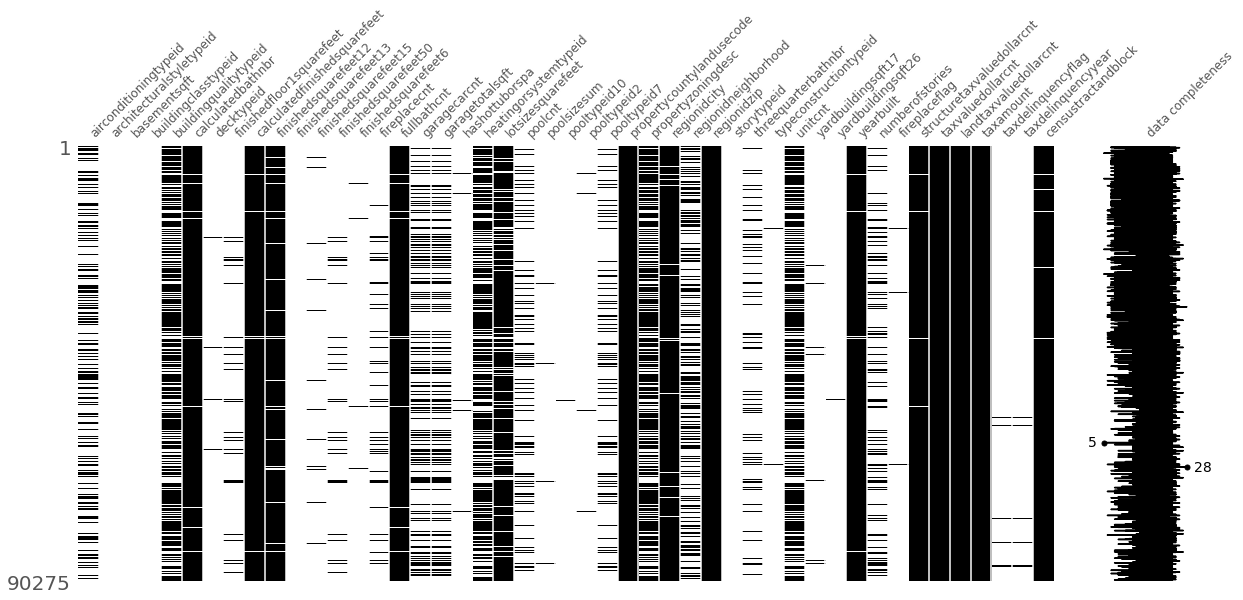

In [35]:
msno.matrix(merged[missing_value_columns], width_ratios=(10,1), \
            figsize=(20,8), color = (0,0,0), fontsize= 12, sparkline=True, labels=True)

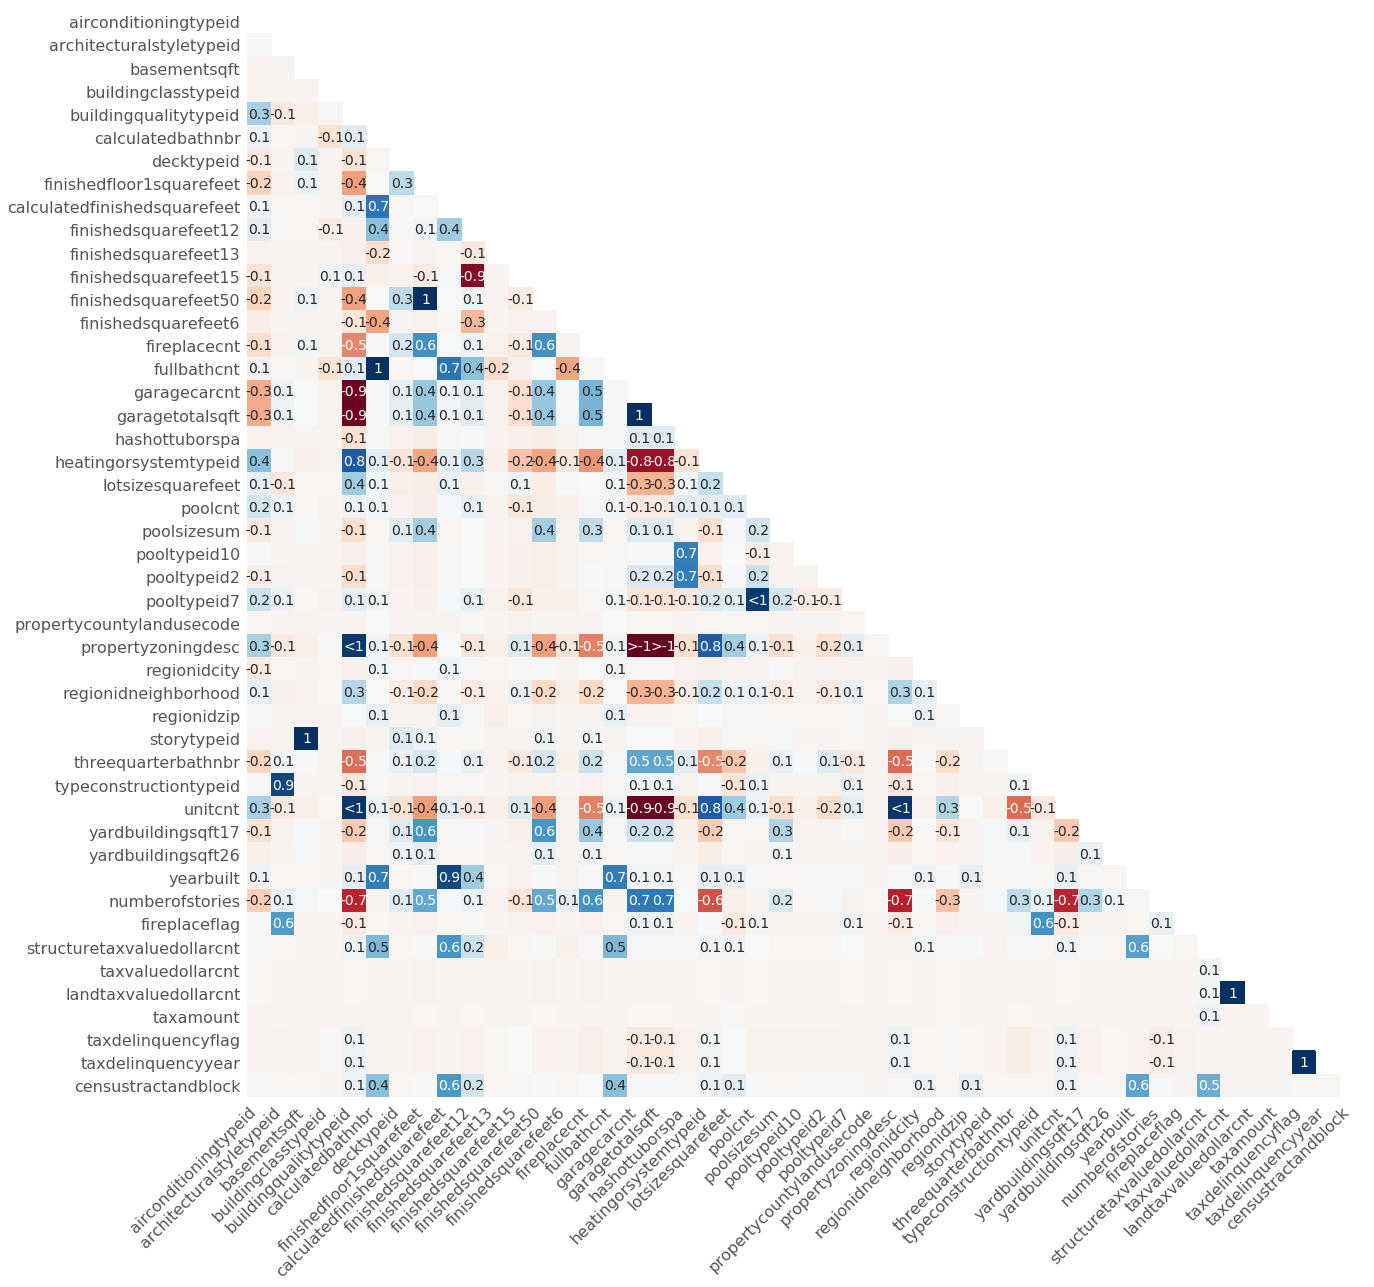

In [36]:
msno.heatmap(merged[missing_value_columns], figsize=(20,20))

### Top Features Selection

In [37]:
from sklearn import model_selection, preprocessing
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

In [38]:
mergedFilterd = merged.fillna(-999)
for f in mergedFilterd.columns:
    if mergedFilterd[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()                         
        lbl.fit(list(mergedFilterd[f].values))                               #fill label encoder  
        mergedFilterd[f] = lbl.transform(list(mergedFilterd[f].values))      #fill with 0

In [45]:
train_y = mergedFilterd['logerror'].values
train_X = mergedFilterd.drop(['parcelid', 'transactiondate', 'logerror'], axis=1)

In [50]:
xgb_params = {
    'eta':0.05,
    'max_depth':8,
    'subsample':0.7,
    'colsample_bytree':0.7,
    'objective':'reg:linear',
    'evalmetric': 'rmse',
    'silent':1
}
dtrain = xgb.DMatrix(train_X, train_y, feature_names = train_X.columns.values) #load data 
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)

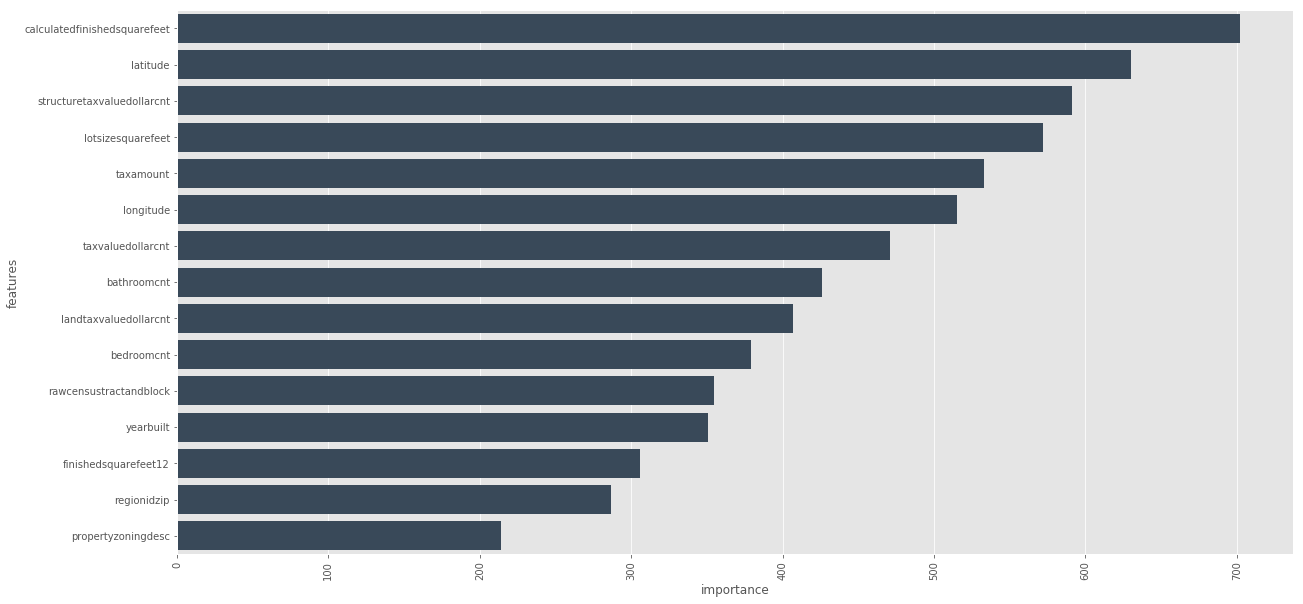

In [62]:
featureImportance = model.get_fscore() #?
features = pd.DataFrame()
features['features'] = featureImportance.keys()
features['importance'] = featureImportance.values()
features.sort_values(by=['importance'], ascending=False, inplace=True)
fig,ax = plt.subplots()
fig.set_size_inches(20,10)
plt.xticks(rotation=90)
sn.barplot(data=features.head(15), x='importance', y='features', ax=ax, orient='h', color='#34495e')

In [64]:
features.head(5)

,features,importance
6,calculatedfinishedsquarefeet,702
26,latitude,630
2,structuretaxvaluedollarcnt,591
4,lotsizesquarefeet,572
0,taxamount,533


### Correlation Analysis

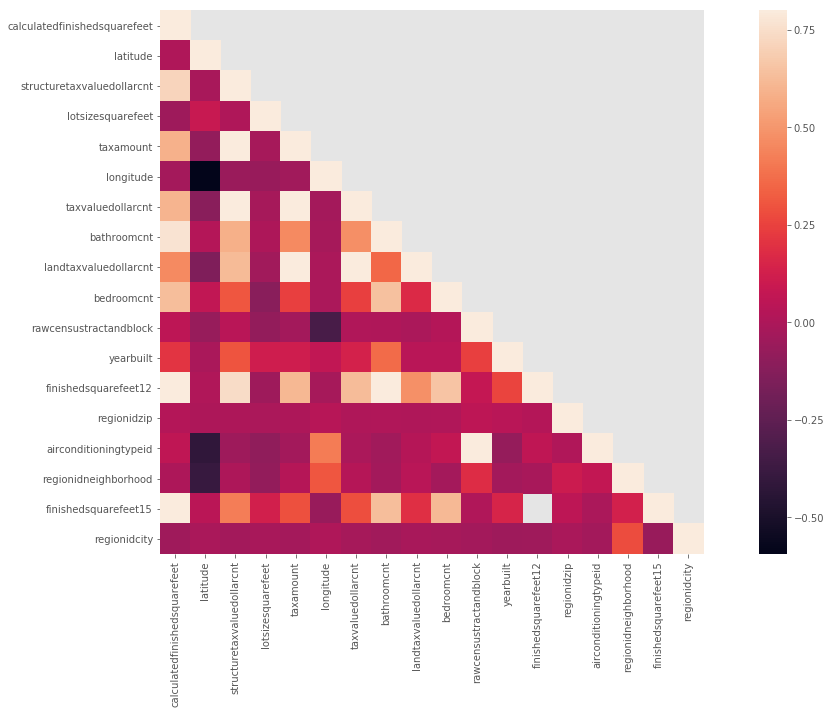

In [79]:
topFeatures = features['features'].tolist()[:20]
corrMatt = merged[topFeatures].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False #?
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask, vmax=.8, square=True) #图不对啊！

In [72]:
mask

array([[ 0.00000000e+00,  9.32097026e-03,  7.16488519e-01,
        -4.87698257e-02,  5.89022465e-01, -2.23685709e-02,
         6.00018181e-01,  7.72552605e-01,  4.58550189e-01,
         6.32034654e-01,  5.86767962e-02,  2.11640900e-01,
         1.00000000e+00,  2.28895066e-02,  5.96669511e-02,
         4.88355211e-03,  1.00000000e+00, -4.18338597e-02],
       [ 0.00000000e+00,  0.00000000e+00, -1.35478096e-02,
         9.19478307e-02, -7.84108737e-02, -5.94096577e-01,
        -1.12393595e-01,  2.27110129e-02, -1.47394117e-01,
         6.63310558e-02, -7.01182362e-02, -7.47465984e-03,
         1.08039925e-02,  2.04810810e-04, -4.17596086e-01,
        -3.90405029e-01,  4.39168682e-02, -8.70537169e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         8.65499675e-03,  7.95013536e-01, -5.98065422e-02,
         8.26052216e-01,  5.86640601e-01,  6.23291904e-01,
         3.05405302e-01,  3.81094657e-02,  2.99695983e-01,
         7.44048406e-01,  2.10612151e-03, -4.73237194e

In [80]:
corrMatt

,calculatedfinishedsquarefeet,latitude,structuretaxvaluedollarcnt,lotsizesquarefeet,taxamount,longitude,taxvaluedollarcnt,bathroomcnt,landtaxvaluedollarcnt,bedroomcnt,rawcensustractandblock,yearbuilt,finishedsquarefeet12,regionidzip,airconditioningtypeid,regionidneighborhood,finishedsquarefeet15,regionidcity
calculatedfinishedsquarefeet,1.000000,0.009321,0.716489,-0.048770,0.589022,-0.022369,0.600018,0.772553,0.458550,0.632035,0.058677,0.211641,1.000000,0.022890,0.059667,0.004884,1.000000,-0.041834
latitude,0.009321,1.000000,-0.013548,0.091948,-0.078411,-0.594097,-0.112394,0.022711,-0.147394,0.066331,-0.070118,-0.007475,0.010804,0.000205,-0.417596,-0.390405,0.043917,-0.008705
structuretaxvaluedollarcnt,0.716489,-0.013548,1.000000,0.008655,0.795014,-0.059807,0.826052,0.586641,0.623292,0.305405,0.038109,0.299696,0.744048,0.002106,-0.047324,0.003416,0.423238,-0.030709
lotsizesquarefeet,-0.048770,0.091948,0.008655,1.000000,-0.022038,-0.065707,-0.021347,-0.000197,-0.034030,-0.113984,-0.079100,0.118078,-0.046706,-0.003748,-0.090773,-0.079076,0.125495,-0.011855
taxamount,0.589022,-0.078411,0.795014,-0.022038,1.000000,-0.035154,0.949376,0.461900,0.902713,0.239118,-0.031046,0.115647,0.612496,0.001434,-0.028251,0.028005,0.291227,-0.026625
longitude,-0.022369,-0.594097,-0.059807,-0.065707,-0.035154,1.000000,-0.024682,-0.018347,-0.004087,-0.004879,-0.327582,0.068977,-0.021118,0.036801,0.415025,0.307451,-0.061608,0.009960
taxvaluedollarcnt,0.600018,-0.112394,0.826052,-0.021347,0.949376,-0.024682,1.000000,0.476363,0.955336,0.241329,0.012442,0.140940,0.626052,0.005689,-0.001102,0.029449,0.287586,-0.021307
bathroomcnt,0.772553,0.022711,0.586641,-0.000197,0.461900,-0.018347,0.476363,1.000000,0.353806,0.646120,0.009713,0.368061,0.799372,0.012265,-0.037479,-0.029097,0.633631,-0.037242
landtaxvaluedollarcnt,0.458550,-0.147394,0.623292,-0.034030,0.902713,-0.004087,0.955336,0.353806,1.000000,0.173205,-0.002037,0.039493,0.480463,0.006802,0.027169,0.038987,0.194818,-0.013734
bedroomcnt,0.632035,0.066331,0.305405,-0.113984,0.239118,-0.004879,0.241329,0.646120,0.173205,1.000000,0.024190,0.040871,0.657599,0.014874,0.075327,-0.024194,0.615172,-0.022166


### Multicollinearity Analysis

In [82]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

In [83]:
def calculate_vif_(X):
    variables = list(X.columns)
    vif = {variable:variance_inflation_factor(exog=X.values, exog_idx=ix) for ix, variable in enumerate(list(X.columns))}
    return vif

In [90]:
numericalCol = []
for f in merged.columns:
    if merged[f].dtype!='object' and f not in ['parcelid', 'transactiondate', 'logerror']:
        numericalCol.append(f)
mergedFilterd = merged[numericalCol].fillna(-999)
vifDict = calculate_vif_(mergedFilterd)

In [105]:
vifDf = pd.DataFrame()
vifDf['variables'] = vifDict.keys()
vifDf['vifScore'] = vifDict.values()
vifDf.sort_values(by=['vifScore'], ascending=False, inplace=True)
vifDf

,variables,vifScore
11,finishedsquarefeet12,7.382950e+13
29,pooltypeid7,1.326398e+10
28,pooltypeid2,8.364667e+09
25,poolcnt,6.496320e+09
10,calculatedfinishedsquarefeet,6.311753e+09
12,finishedsquarefeet13,5.357248e+09
13,finishedsquarefeet15,2.637224e+09
15,finishedsquarefeet6,1.535908e+09
46,taxvaluedollarcnt,1.287209e+08
48,landtaxvaluedollarcnt,6.705584e+07


In [106]:
validVariables = vifDf[vifDf['vifScore']<=5]
variablesWithMC = vifDf[vifDf['vifScore']>5]

[Text(0, 0.5, 'Features'),
 Text(0.5, 0, 'VIF Scores'),
 Text(0.5, 1.0, 'Variables Which Exhibit Multicollinearity')]

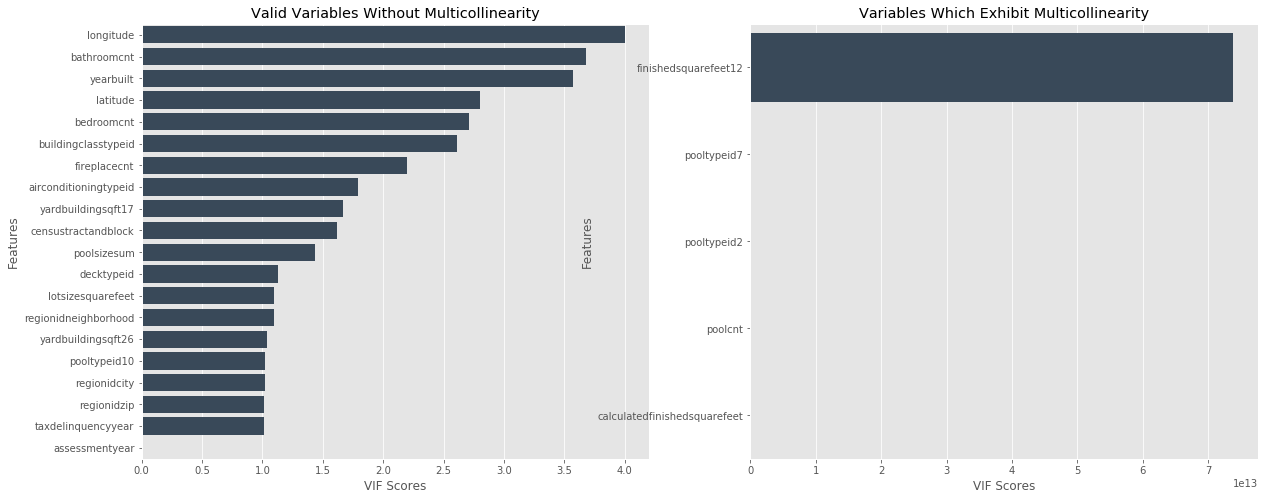

In [108]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
fig.set_size_inches(20,8)
sn.barplot(data=validVariables, x='vifScore', y='variables', ax=ax1, orient='h', color='#34495e')
sn.barplot(data=variablesWithMC.head(5), x='vifScore', y='variables', ax=ax2, orient='h', color='#34495e')
ax1.set(xlabel='VIF Scores', ylabel='Features',title="Valid Variables Without Multicollinearity")
ax2.set(xlabel='VIF Scores', ylabel='Features',title="Variables Which Exhibit Multicollinearity") #?

### Univariate Analysis
#### Dependent variable logerror follows nice normal distribution

In [111]:
ulimit = np.percentile(merged.logerror.values, 99)
llimit = np.percentile(merged.logerror.values, 1)

In [112]:
ulimit

0.4638819999999963

In [113]:
llimit

-0.3425